In [1]:
import numpy as np
import pandas as pd

%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
!pip install fastai==0.7.0 --quiet

You are using pip version 19.0.3, however version 19.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import MultiLabelBinarizer

from IPython.display import display

from sklearn import metrics

import ast

# The data

In [4]:
PATH = "../input/"
!ls {PATH}

sample_submission.csv  test.csv  train.csv


In [5]:
df_raw = pd.read_csv(f'{PATH}train.csv', 
                     low_memory=False, 
                     parse_dates=["release_date"])

In [6]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [7]:
# look at the data
display_all(df_raw.tail().T)

,2995,2996,2997,2998,2999
id,2996,2997,2998,2999,3000
belongs_to_collection,NaN,NaN,NaN,NaN,NaN
budget,0,0,65000000,42000000,35000000
genres,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...","[{'id': 18, 'name': 'Drama'}, {'id': 10402, 'n...","[{'id': 80, 'name': 'Crime'}, {'id': 28, 'name...","[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...","[{'id': 53, 'name': 'Thriller'}, {'id': 28, 'n..."
homepage,NaN,NaN,NaN,http://www.alongcamepolly.com/,http://www.abductionthefilm.com/
imdb_id,tt0109403,tt2364975,tt0116908,tt0343135,tt1600195
original_language,en,sv,en,en,en
original_title,Chasers,Vi är bäst!,The Long Kiss Goodnight,Along Came Polly,Abduction
overview,Military men Rock Reilly and Eddie Devane are ...,Three girls in 1980s Stockholm decide to form ...,"Samantha Caine, suburban homemaker, is the ide...",Reuben Feffer is a guy who's spent his entire ...,A young man sets out to uncover the truth abou...
popularity,9.85327,3.728,14.4823,15.7255,10.5121


In [ ]:
# describe all the data
display_all(df_raw.describe(include='all').T)

In [9]:
df_raw.dtypes

id                                int64
belongs_to_collection            object
budget                            int64
genres                           object
homepage                         object
imdb_id                          object
original_language                object
original_title                   object
overview                         object
popularity                      float64
poster_path                      object
production_companies             object
production_countries             object
release_date             datetime64[ns]
runtime                         float64
spoken_languages                 object
status                           object
tagline                          object
title                            object
Keywords                         object
cast                             object
crew                             object
revenue                         float64
dtype: object

Metric to use:  Root-Mean-Squared-Logarithmic-Error (RMSLE) between the predicted value and the actual revenue. Logs are taken to not overweight blockbuster revenue movies.

In [8]:
df_raw.revenue = np.log1p(df_raw.revenue)

## Initial processing

In [10]:
# transform release_date to multiple new columns containing information from the date
add_datepart(df_raw, 'release_date')
df_raw.dtypes

id                            int64
belongs_to_collection        object
budget                        int64
genres                       object
homepage                     object
imdb_id                      object
original_language            object
original_title               object
overview                     object
popularity                  float64
poster_path                  object
production_companies         object
production_countries         object
runtime                     float64
spoken_languages             object
status                       object
tagline                      object
title                        object
Keywords                     object
cast                         object
crew                         object
revenue                     float64
release_Year                  int64
release_Month                 int64
release_Week                  int64
release_Day                   int64
release_Dayofweek             int64
release_Dayofyear           

We need to take care of some fields that seem important:
- `genres` => extract the names & one-hot encode
- `production_companies`, `production_countries`, `spoken_languages`, `Keywords` => extract the names & one-hot encode the most common ones
- `cast` => extract the length
- `crew` => extract some interesting names and the length

In [11]:
# we'll use it for one-hot encoding
mlb = MultiLabelBinarizer()

### Genres

In [12]:
# look at a random movie genres
df_raw.iloc[1300]['genres']

"[{'id': 27, 'name': 'Horror'}, {'id': 35, 'name': 'Comedy'}, {'id': 10749, 'name': 'Romance'}]"

Let's define functions to extract a list of genres for each row and hot encode them.

In [13]:
def convertStringToList(strVal):
    if type(strVal) is not str:
        return  []
    else:
        return ast.literal_eval(strVal)

In [14]:
def formatDictColumnAndExtractNames(strVal):
    listOfItems = convertStringToList(strVal)
    return list(map(lambda x: x['name'], listOfItems))

In [15]:
def extractGenres(df):
    df['genres'] = df['genres'].apply(formatDictColumnAndExtractNames)

    return df.join(pd.DataFrame(mlb.fit_transform(df.pop('genres')),
                          columns=list(map(lambda x: 'genre_'+x,mlb.classes_)),
                          index=df.index))

In [16]:
df_raw = extractGenres(df_raw)

### Production companies

In [17]:
def extractCommonProdCompanies(df):
    df['production_companies'] = df['production_companies'].apply(formatDictColumnAndExtractNames)

    companiesCount = df['production_companies'].apply(pd.Series).stack().value_counts()
    companiesToKeep = companiesCount[companiesCount > 30].keys()
    print("We'll keep the companies that appear more than 30 times:")
    print(companiesToKeep)

    df['production_companies'] = df['production_companies'].apply(lambda x: list(filter(lambda i: i in companiesToKeep, x)))

    return df.join(pd.DataFrame(mlb.fit_transform(df.pop('production_companies')),
                          columns=list(map(lambda x: 'prod_company_'+x,mlb.classes_)),
                          index=df.index))

In [18]:
df_raw = extractCommonProdCompanies(df_raw)

We'll keep the companies that appear more than 30 times:
Index(['Warner Bros.', 'Universal Pictures', 'Paramount Pictures',
       'Twentieth Century Fox Film Corporation', 'Columbia Pictures',
       'Metro-Goldwyn-Mayer (MGM)', 'New Line Cinema', 'Touchstone Pictures',
       'Walt Disney Pictures', 'Columbia Pictures Corporation',
       'TriStar Pictures', 'Relativity Media', 'Canal+', 'United Artists',
       'Miramax Films', 'Village Roadshow Pictures', 'Regency Enterprises'],
      dtype='object')


### Production countries

In [19]:
def extractCommonProdCountries(df):
    df['production_countries'] = df['production_countries'].apply(formatDictColumnAndExtractNames)

    countriesCount = df['production_countries'].apply(pd.Series).stack().value_counts()
    countriesToKeep = countriesCount[countriesCount > 10].keys()
    print("We'll keep the countries that appear more than 10 times:")
    print(countriesToKeep)

    df['production_countries'] = df['production_countries'].apply(lambda x: list(filter(lambda i: i in countriesToKeep, x)))
    return df.join(pd.DataFrame(mlb.fit_transform(df.pop('production_countries')),
                          columns=list(map(lambda x: 'prod_country_'+x,mlb.classes_)),
                          index=df.index))

In [20]:
df_raw = extractCommonProdCountries(df_raw)

We'll keep the countries that appear more than 10 times:
Index(['United States of America', 'United Kingdom', 'France', 'Germany',
       'Canada', 'India', 'Italy', 'Australia', 'Japan', 'Russia', 'Spain',
       'China', 'Hong Kong', 'Belgium', 'Ireland', 'South Korea', 'Mexico',
       'Sweden', 'New Zealand', 'Netherlands', 'Czech Republic', 'Denmark',
       'Brazil'],
      dtype='object')


### Spoken languages

In [21]:
def extractCommonSpokenLanguages(df):
    df['spoken_languages'] = df['spoken_languages'].apply(formatDictColumnAndExtractNames)

    languageCount = df['spoken_languages'].apply(pd.Series).stack().value_counts()
    languagesToKeep = languageCount[languageCount > 10].keys()
    print("We'll keep the languages that appear more than 10 times:")
    print(languagesToKeep)

    df['spoken_languages'] = df['spoken_languages'].apply(lambda x: list(filter(lambda i: i in languagesToKeep, x)))

    return df.join(pd.DataFrame(mlb.fit_transform(df.pop('spoken_languages')),
                          columns=list(map(lambda x: 'spoken_language_'+x,mlb.classes_)),
                          index=df.index))

In [22]:
df_raw = extractCommonSpokenLanguages(df_raw)

We'll keep the languages that appear more than 10 times:
Index(['English', 'Français', 'Español', 'Deutsch', 'Pусский', 'Italiano',
       '日本語', '普通话', 'हिन्दी', '', 'Português', 'العربية', '한국어/조선말',
       '广州话 / 廣州話', 'தமிழ்', 'Polski', 'Magyar', 'Latin', 'ภาษาไทย', 'svenska',
       'Český', 'עִבְרִית', 'ελληνικά', 'Dansk', 'Türkçe'],
      dtype='object')


### Keywords

In [23]:
def extractCommonKeywords(df):
    df['Keywords'] = df['Keywords'].apply(formatDictColumnAndExtractNames)

    keywordCount = df['Keywords'].apply(pd.Series).stack().value_counts()
    keywordsToKeep = keywordCount[keywordCount >= 30].keys()
    print("We'll keep the keywords that appear more than 30 times:")
    print(keywordsToKeep)

    df['Keywords'] = df['Keywords'].apply(lambda x: list(filter(lambda i: i in keywordsToKeep, x)))

    return df.join(pd.DataFrame(mlb.fit_transform(df.pop('Keywords')),
                          columns=list(map(lambda x: 'keyword_'+x,mlb.classes_)),
                          index=df.index))

In [24]:
df_raw = extractCommonKeywords(df_raw)

We'll keep the keywords that appear more than 30 times:
Index(['woman director', 'independent film', 'duringcreditsstinger', 'murder',
       'based on novel', 'violence', 'sport', 'biography',
       'aftercreditsstinger', 'dystopia', 'revenge', 'friendship', 'sex',
       'suspense', 'sequel', 'love', 'police', 'teenager', 'nudity',
       'female nudity', 'drug', 'prison', 'musical', 'high school',
       'los angeles', 'new york', 'family', 'father son relationship',
       'investigation', 'kidnapping', '3d', 'wedding', 'london england',
       'detective', 'paris', 'based on comic', 'robbery',
       'based on true story', 'prostitute', 'alien', 'dying and death',
       'escape', 'brother brother relationship', 'suicide', 'corruption',
       'rape', 'death', 'superhero', 'martial arts', 'remake', 'jealousy',
       'new york city', 'brother sister relationship', 'magic', 'world war ii',
       'hospital', 'soldier'],
      dtype='object')


### Cast

In [25]:
# have a look at a cast cell
df_raw.iloc[3]['cast']

"[{'cast_id': 1, 'character': 'Vidya Bagchi', 'credit_id': '52fe48779251416c9108d6d9', 'gender': 1, 'id': 35068, 'name': 'Vidya Balan', 'order': 0, 'profile_path': '/anMmmqKY11jcm0UnSSakfNOSCyB.jpg'}, {'cast_id': 5, 'character': '', 'credit_id': '57722abec3a368245b004519', 'gender': 2, 'id': 85047, 'name': 'Nawazuddin Siddiqui', 'order': 1, 'profile_path': '/2Kv2ENAs1ETAFTQ6mC1jbDzEzIN.jpg'}, {'cast_id': 6, 'character': '', 'credit_id': '57722aea9251411dca003f8f', 'gender': 0, 'id': 1021524, 'name': 'Parambrata Chatterjee', 'order': 2, 'profile_path': '/Aif4X9ihmRrVzX1cbWDDznk8HZV.jpg'}, {'cast_id': 7, 'character': '', 'credit_id': '57722b069251411dcd003f73', 'gender': 0, 'id': 1093644, 'name': 'Saswata Chatterjee', 'order': 3, 'profile_path': '/vuHaLzSVRIo7pXSmhB7ko6YmNs.jpg'}, {'cast_id': 8, 'character': '', 'credit_id': '57722b26c3a36869a2000745', 'gender': 0, 'id': 86033, 'name': 'Indraneil Sengupta', 'order': 4, 'profile_path': '/4hLg7XIJdhrS3t0h5Q8vQxnp4DZ.jpg'}, {'cast_id': 9, '

In [26]:
def addCastLengthColumn(df):
    castNames = df['cast'].apply(formatDictColumnAndExtractNames)
    df['cast_len'] = castNames.apply(lambda x: len(x))
    return df

In [27]:
df_raw = addCastLengthColumn(df_raw)

In [28]:
df_raw.drop(['cast'], axis=1, inplace=True)

### Crew

In [29]:
# have a look at a crew cell
df_raw.iloc[113]['crew']

'[{\'credit_id\': \'52fe47d49251416c750a6db1\', \'department\': \'Directing\', \'gender\': 2, \'id\': 5342, \'job\': \'Director\', \'name\': \'Mike Nichols\', \'profile_path\': \'/eJgJEVil7iOJ9sTAXLCVRKfeKKM.jpg\'}, {\'credit_id\': \'56d92526925141391f00dab4\', \'department\': \'Writing\', \'gender\': 2, \'id\': 584535, \'job\': \'Screenplay\', \'name\': \'Neil Simon\', \'profile_path\': \'/qZ5iSAEcV7hCVYIOrOD4CI2J5Wi.jpg\'}, {\'credit_id\': \'56d9252dc3a3681e36020ffb\', \'department\': \'Writing\', \'gender\': 2, \'id\': 584535, \'job\': \'Theatre Play\', \'name\': \'Neil Simon\', \'profile_path\': \'/qZ5iSAEcV7hCVYIOrOD4CI2J5Wi.jpg\'}, {\'credit_id\': \'56d925399251416ff2005b60\', \'department\': \'Production\', \'gender\': 2, \'id\': 70778, \'job\': \'Executive Producer\', \'name\': \'Joseph M. Caracciolo\', \'profile_path\': None}, {\'credit_id\': \'56d925739251416ff2005b69\', \'department\': \'Production\', \'gender\': 1, \'id\': 71762, \'job\': \'Executive Producer\', \'name\': \

Interesting crew jobs: Director, Screenplay, Director of Photography, Original Music Composer, Art Direction

In [30]:
def formatDictColumnAndExtractJobName(strVal, job):
    listOfItems = convertStringToList(strVal)
    
    jobItem = (list(filter(lambda lst: lst['job'] == job, listOfItems)) or [None])[0]
    if type(jobItem) is dict:
        return jobItem['name']
    else:
        return None

In [31]:
def addCrewJobsColumns(df):
    df['director'] = df['crew'].apply(formatDictColumnAndExtractJobName, args=('Director',))
    df['screenplay'] = df['crew'].apply(formatDictColumnAndExtractJobName, args=('Screenplay',))
    df['director_of_photography'] = df['crew'].apply(formatDictColumnAndExtractJobName, args=('Director of Photography',))
    df['original_music_composer'] = df['crew'].apply(formatDictColumnAndExtractJobName, args=('Original Music Composer',))
    df['art_director'] = df['crew'].apply(formatDictColumnAndExtractJobName, args=('Art Direction',))
    
    return df

In [32]:
df_raw = addCrewJobsColumns(df_raw)

Add a column for the Director gender, could be interesting

In [33]:
def formatDictColumnAndExtractDirectorGender(strVal):
    listOfItems = convertStringToList(strVal)

    directorItem = (list(filter(lambda lst: lst['job'] == 'Director', listOfItems)) or [None])[0]
    if type(directorItem) is dict:
        return directorItem['gender']
    else:
        return None

In [34]:
def addDirectorGenderColumn(df):
    df['director_gender'] = df['crew'].apply(formatDictColumnAndExtractDirectorGender)
    return df

In [35]:
df_raw = addDirectorGenderColumn(df_raw)

Add the crew length

In [36]:
def addCrewLenghtColumn(df):
    df['crew'] = df['crew'].apply(formatDictColumnAndExtractNames)
    df['crew_len'] = df['crew'].apply(lambda x: len(x))
    return df

In [37]:
df_raw = addCrewLenghtColumn(df_raw)

In [38]:
# drop crew column
df_raw.drop(['crew'], axis=1, inplace=True)

### Homepage

In [39]:
df_raw['has_homepage'] = df_raw['homepage'].apply(lambda x: isinstance(x, str))

### Belongs_to_collection

In [40]:
# look at a random cell
df_raw.iloc[8]['belongs_to_collection']

"[{'id': 256377, 'name': 'The Muppet Collection', 'poster_path': '/8Ew8EIdFFurMMYjSbWPu1Hl4vLX.jpg', 'backdrop_path': '/1AWd3MM90G47mxtD112gRDxSXY9.jpg'}]"

We'll transform `belongs_to_collection` to a bool

In [41]:
df_raw['belongs_to_collection'] = df_raw['belongs_to_collection'].apply(lambda x: isinstance(x, str))

### Tagline

In [42]:
def extractTaglineInfo(df):
    df['has_tagline'] = df['tagline'].apply(lambda x: isinstance(x, str))
    df['tagline_len'] = df['tagline'].apply(lambda x: len(x) if isinstance(x, str) else 0)
    return df

In [43]:
df_raw = extractTaglineInfo(df_raw)

In [44]:
# check the result
df_raw[['tagline', 'has_tagline', 'tagline_len']].head(8)

,tagline,has_tagline,tagline_len
0,The Laws of Space and Time are About to be Vio...,True,52
1,It can take a lifetime to find true love; she'...,True,60
2,The road to greatness can take you to the edge.,True,47
3,NaN,False,0
4,NaN,False,0
5,NaN,False,0
6,Fear The Demon That Doesn't Fear God,True,36
7,Different channels. Different truths.,True,37


### Overview

In [45]:
def extractOverviewInfo(df):
    df['has_overview'] = df['overview'].apply(lambda x: isinstance(x, str))
    df['overview_len'] = df['overview'].apply(lambda x: len(x) if isinstance(x, str) else 0)
    return df

In [46]:
df_raw = extractOverviewInfo(df_raw)

In [47]:
# check the result
df_raw[['overview', 'has_overview', 'overview_len']].head(8)

,overview,has_overview,overview_len
0,"When Lou, who has become the ""father of the In...",True,155
1,Mia Thermopolis is now a college graduate and ...,True,393
2,"Under the direction of a ruthless instructor, ...",True,130
3,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,True,581
4,Marine Boy is the story of a former national s...,True,168
5,"Pinocchio and his friends, a glow worm and a m...",True,150
6,A young girl buys an antique box at a yard sal...,True,208
7,A chronicle which provides a rare window into ...,True,501


### Budget

In [48]:
# we noticed quite a lot of movies with budget 0...
df_raw['has_budget'] = df_raw['budget'].apply(lambda x: x > 0)

### Remove biased or unusable features

In [49]:
toRemove = ['imdb_id', 'id', 'poster_path', 'overview', 'homepage', 'tagline', 'original_title', 'status']
df_raw.drop(toRemove, axis=1, inplace=True)

### Train categories

Convert strings to pandas categories

In [50]:
train_cats(df_raw)

## Pre-processing

- Apply proc_df: proc_df takes a data frame df and splits off the response variable, and
    changes the df into an entirely numeric dataframe.
- Check the initial score on all the dataframe
- Split vals into training set and validation set

In [51]:
df_trn, y_trn, nas = proc_df(df_raw, 'revenue')

In [52]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(df_trn, y_trn)
m.score(df_trn,y_trn)

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.9045912031888629

In [53]:
def split_vals(a,n): return a[:n], a[n:]
n_valid = 600 # 20%
n_trn = len(df_trn)-n_valid
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)
raw_train, raw_valid = split_vals(df_raw, n_trn)

# Random forest

In [54]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

# print_score function depending on the evaluation metric: rmse
def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [57]:
#rf with hyper parameters
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=10, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[1.7640702939734767, 1.935635004048337, 0.6785780315466408, 0.5370753974173486, 0.5023794074498195]


# Feature importance

Goal: plot the feature importance, keep the best features and see if it improves the score

In [58]:
fi = rf_feat_importance(m, df_trn)
fi

,cols,imp
1,budget,0.370303
3,popularity,0.240728
18,release_Elapsed,0.056387
174,has_budget,0.051944
161,cast_len,0.031140
4,runtime,0.026623
6,release_Year,0.018939
168,crew_len,0.016727
162,director,0.016381
0,belongs_to_collection,0.015549


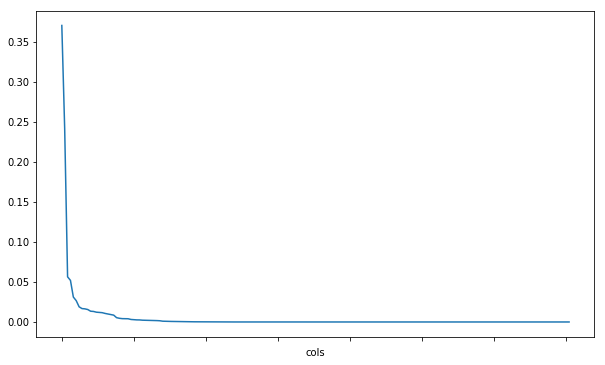

In [59]:
fi.plot('cols', 'imp', figsize=(10,6), legend=False);

Some features have a very strong importance and most seem to not be useful at all!

In [60]:
# function to plot feature importance
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,12), legend=False)

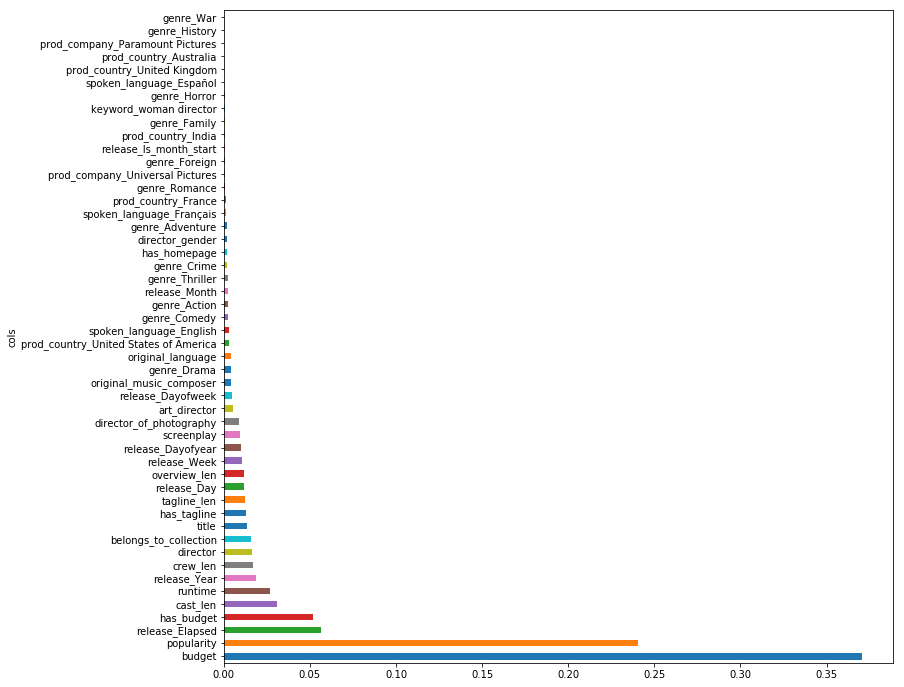

In [61]:
# plot the top 50 features
plot_fi(fi[:50]);

In [77]:
# we'll keep the top ~30 features
to_keep = fi[fi.imp>0.002].cols; len(to_keep)

31

In [78]:
df_keep = df_trn[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

In [79]:
# new model with only the top ~30 features
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=10, max_features=0.5,
                          n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[1.7626032132385814, 1.9399226493893982, 0.6791124273667075, 0.5350222677213231, 0.4954534974480028]


It seems to have improved a bit!

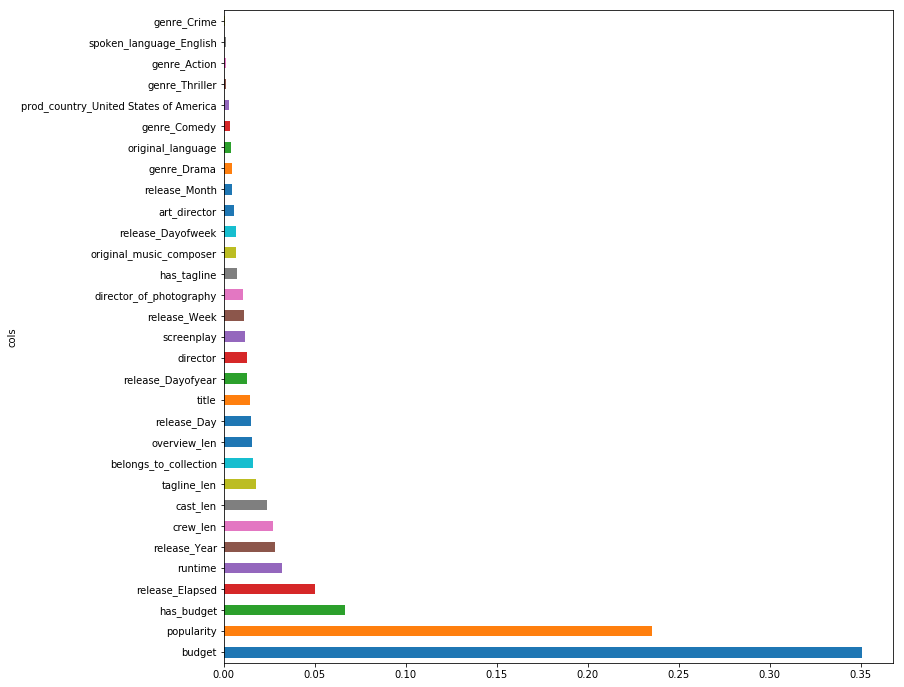

In [80]:
# plot the new feature importance
fi = rf_feat_importance(m, df_keep)
plot_fi(fi);

# Removing redundant features

- Dendrogram plot
- Write a function to get the OOB score for a dataframe
- Get the OOB score of the base dataframe
- Remove some of the related features one at a time to see if the model can be simplified without impacting the accuracy
- Check the OOB score of the final dataframe
- Get the final columns to keep

In [81]:
from scipy.cluster import hierarchy as hc

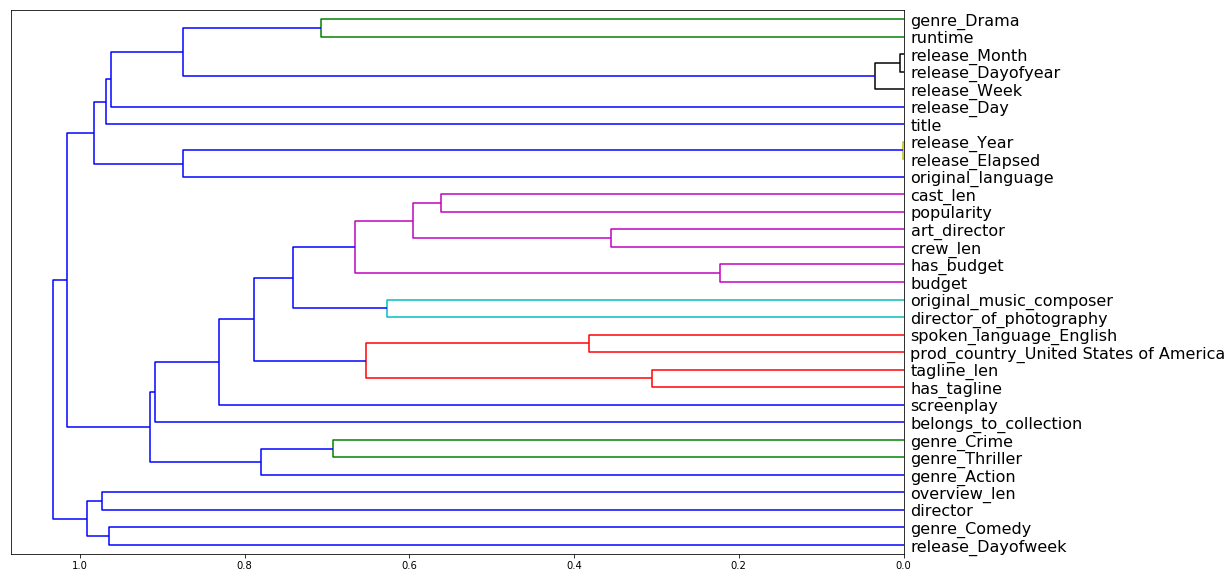

In [82]:
# dendrogram plot
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

In [83]:
# function to get the OOB score for a given datraframe (with the same hyperparameters as before)
def get_oob(df):
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=10, max_features=0.5, n_jobs=-1, oob_score=True)
    x, _ = split_vals(df, n_trn)
    m.fit(x, y_train)
    return m.oob_score_

In [85]:
# check the current OOB score
get_oob(df_keep)

0.4939568188672989

Some features seem strongly related:
- release_Month, release_Dayofyear and release_Week
- release_Year and release_Elapsed.
Maybe removing one of each group will get a better score, and some other features will gain importance.

In [86]:
for c in ('release_Month', 'release_Dayofyear', 'release_Week', 'release_Year', 'release_Elapsed'):
    print(c, get_oob(df_keep.drop(c, axis=1)))

release_Month 0.5004644571167898
release_Dayofyear 0.49400629527970275
release_Week 0.4977757475605834
release_Year 0.48809233269730545
release_Elapsed 0.4964428844612472


We'll drop the one in each group without which the OOB score improves: `release_Week` and `release_Year`, and check the new score.

In [87]:
to_drop = ['release_Month', 'release_Elapsed']
get_oob(df_keep.drop(to_drop, axis=1))

0.49403103060833353

Hmm... Depends but the model seems better without these 2 columns, let's drop them.

In [88]:
df_keep.drop(to_drop, axis=1, inplace=True)
X_train, X_valid = split_vals(df_keep, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)

# Final model

In [150]:
m = RandomForestRegressor(n_estimators=100, min_samples_leaf=10, max_features=0.5,
                          n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[1.7738022661820414, 1.9482287595831322, 0.6750218262216514, 0.5310319802486986, 0.5006341138182119]


# Submission on test set

In [151]:
df_test = pd.read_csv(f'{PATH}test.csv', 
                     low_memory=False, 
                     parse_dates=["release_date"])

We'll apply on it the same transformations as on the training dataset.

In [152]:
add_datepart(df_test, 'release_date')

df_test = extractGenres(df_test)
df_test = extractCommonProdCompanies(df_test)
df_test = extractCommonProdCountries(df_test)
df_test = extractCommonSpokenLanguages(df_test)
df_test = extractCommonKeywords(df_test)
df_test = addCastLengthColumn(df_test)
df_test.drop(['cast'], axis=1, inplace=True)
df_test = addCrewJobsColumns(df_test)
df_test = addDirectorGenderColumn(df_test)
df_test = addCrewLenghtColumn(df_test)
df_test.drop(['crew'], axis=1, inplace=True)
df_test['has_homepage'] = df_test['homepage'].apply(lambda x: isinstance(x, str))
df_test['belongs_to_collection'] = df_test['belongs_to_collection'].apply(lambda x: isinstance(x, str))
df_test = extractTaglineInfo(df_test)
df_test = extractOverviewInfo(df_test)
df_test['has_budget'] = df_test['budget'].apply(lambda x: x > 0)
df_test.drop(toRemove, axis=1, inplace=True)

We'll keep the companies that appear more than 30 times:
Index(['Warner Bros.', 'Universal Pictures', 'Paramount Pictures',
       'Twentieth Century Fox Film Corporation', 'Columbia Pictures',
       'New Line Cinema', 'Metro-Goldwyn-Mayer (MGM)', 'Touchstone Pictures',
       'Walt Disney Pictures', 'Canal+', 'Columbia Pictures Corporation',
       'TriStar Pictures', 'Relativity Media', 'Miramax Films',
       'United Artists', 'Village Roadshow Pictures', 'DreamWorks SKG',
       'Regency Enterprises', 'Amblin Entertainment',
       'Fox Searchlight Pictures', 'Lionsgate', 'StudioCanal',
       'Summit Entertainment', 'Dimension Films', 'Working Title Films',
       'Orion Pictures', 'Dune Entertainment', 'Imagine Entertainment',
       'Film4', 'Hollywood Pictures'],
      dtype='object')
We'll keep the countries that appear more than 10 times:
Index(['United States of America', 'United Kingdom', 'France', 'Germany',
       'Canada', 'India', 'Japan', 'Italy', 'Australia', 'Spain'

In [153]:
# apply the same categories
apply_cats(df_test, df_raw)

In [154]:
# process the test dataframe
df_test,_,nas = proc_df(df_test,na_dict = nas)

In [155]:
# keep the most important features & some redundant
df_test_keep = df_test[to_keep].copy()
df_test_keep.drop(to_drop, axis=1, inplace=True)

In [156]:
# predict!
predictions = m.predict(df_test_keep)

In [157]:
# copy of the initial test set, to get the ids
df_test_raw = pd.read_csv(f'{PATH}test.csv', low_memory = False)

In [158]:
submission = pd.DataFrame({'id': df_test_raw['id'], 'revenue': np.expm1(predictions)})

In [159]:
submission

,id,revenue
0,3001,4.726544e+05
1,3002,1.980208e+05
2,3003,5.926111e+06
3,3004,5.877410e+06
4,3005,7.004967e+05
5,3006,1.010007e+06
6,3007,1.500136e+06
7,3008,2.400188e+07
8,3009,1.829692e+07
9,3010,2.860194e+08


In [160]:
submission.to_csv('tmdb_predictions_kaggle.csv', index=False)